In [1]:
# Load packages
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.impute import SimpleImputer
from pathlib import Path
import shared_functions as sf

In [2]:
# Defining model name
model_name = 'MultiModalModel'
file_name = 'property-sales_new-york-city_2022_pre-processed'

In [3]:
# Create output directory for exports
Path(f'../models/{model_name}').mkdir(parents=True, exist_ok=True)

In [4]:
# Load subset keys as list
subset_keys = pd.read_csv(f'../data/processed/subset_keys.csv').squeeze().to_list()

In [5]:
# Load subset index as series
subset_index = pd.read_csv(f'../data/processed/subset_index.csv', index_col=0)

In [6]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type
print(f'Device type: {device.upper()}')

Device type: CPU


In [7]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [8]:
dataset_params = {
    'data': f'../data/processed/{file_name}.parquet',
    'target_name': 'sale_price',
    'to_drop': 'sale_price_adj',
    'image_directory': '../data/raw/satellite-images_new-york-city_2022_640x640_19/',
    'image_transformation': transforms.Compose([
        transforms.CenterCrop((600, 600)), # crop image borders by margin of 20px to remove text from 640x640
        transforms.Resize((299, 299)), # resize image to 299x299
        transforms.ToTensor()  # convert image to PyTorch tensor
        # transforms.Normalize() # use imagenet defaults
        ]),
    'subset_index': '../data/processed/subset_index.csv',
    'input_scaler': StandardScaler(),
    'target_scaler': None,
    'categorical_encoder': TargetEncoder(),
    'numerical_imputer': SimpleImputer(missing_values=pd.NA, strategy='mean'),
    'data_overview': f'../data/processed/{file_name}_data-overview.csv'
    }

In [9]:
# Instantiate datasets
subsets = {subset_key: sf.MultiModalDataset(**dataset_params, subset=subset_key) for subset_key in subset_keys}
dataset = sf.MultiModalDataset(**dataset_params)

In [10]:
# Define model architecture
class MultiModalModel(nn.Module):
    # Define model components
    def __init__(self):
        # Inherit from parent class
        super(MultiModalModel, self).__init__()

        # Define text model
        self.TextModel = nn.Sequential(
            nn.Linear(25, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
            )
        
        # Define image model
        self.ImageModel = inception_v3(weights=Inception_V3_Weights.DEFAULT)
        self.ImageModel.AuxLogits.fc = nn.Linear(768, 1)
        self.ImageModel.fc = nn.Linear(2048, 1)
        # model = models.resnet101(pretrained=True)
        # num_ftrs = model.fc.in_features
        # model.fc = nn.Linear(num_ftrs, 1)

        # why freeze blocks?
        # for param in model.parameters():
        #      param.requires_grad = False # False when you freeze the layer / True when you want to train it

        # Define final layer
        self.FinalLayer = nn.Linear(2, 1)

        # Define acitvation function
        self.relu = nn.ReLU(inplace=True)
    
    # Define forward pass
    def forward(self, X_text, X_image):
        X_text = self.TextModel(X_text)
        X_image = self.ImageModel(X_image).logits
        y = self.FinalLayer(torch.cat((X_text, X_image), dim=1))
        return y

In [11]:
# Instantiate model
model = MultiModalModel()

In [12]:
# Calculate number of model parameters
n_params = sum(parameter.numel() for parameter in model.parameters())
print(f'# model paramters: {n_params}')

# model paramters: 24349862


In [13]:
# Pass model to GPU
model.to(device)

MultiModalModel(
  (TextModel): Sequential(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (ImageModel): Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, 

In [14]:
epochs = 5

# Define hyperparameters
batch_size = 64
learning_rate = .05

In [15]:
# Define loss function
loss_function = nn.MSELoss().to(device)

In [16]:
# Define optimization alogrithm
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

In [17]:
# Create data loaders
dataloader_train = DataLoader(subsets['train'], batch_size=batch_size, num_workers=2)
dataloader_val = DataLoader(subsets['val'], batch_size=batch_size, num_workers=2)

In [18]:
# Create data frame for storing training history
history = pd.DataFrame({
    'RMSE_train': np.nan,
    'RMSE_val': np.nan
    }, index=pd.Index(np.arange(epochs) + 1, name='epoch'))

In [19]:
# Training loop
for epoch in np.arange(epochs) + 1:
    # Train model
    model.train()
    batch_losses_train = []
    for i, sample in enumerate(dataloader_train):
        # Pass batch to GPU
        X, y = [X.to(device) for X in sample[:-1]], sample[-1].to(device)

        # Reset gradients
        model.zero_grad()

        # Forward pass
        output_train = model(*X)
        batch_loss_train = loss_function(output_train, y)

        # Backward pass
        batch_loss_train.backward()
        optimizer.step()

        # Store batch loss
        batch_losses_train.append(batch_loss_train.data.item())
    
    # Calculate training loss
    epoch_rmse_train = np.mean(batch_losses_train)**.5

    # Store training loss in history
    history.RMSE_train.loc[epoch] = epoch_rmse_train.item()

    # Calculate validation loss
    model.eval() # deactivates potential Dropout and BatchNorm
    batch_losses_val = []
    for i, sample in enumerate(dataloader_val):
        with torch.no_grad():
            # Pass batch to GPU
            X, y = [X.to(device) for X in sample[:-1]], sample[-1].to(device)

            # Forward pass
            output_val = model(*X)
            batch_loss_val = loss_function(output_val, y)

            # Store batch loss
            batch_losses_val.append(batch_loss_val.data.item())

    # Calculate validation loss
    epoch_rmse_val = epoch_rmse_train = np.mean(batch_losses_val)**.5

    # Store validation loss in history
    history.RMSE_val.loc[epoch] = epoch_rmse_val.item()
    
    # Print progress to console
    print(f'Epoch {epoch:{len(str(epochs))}.0f}/{epochs}: RMSE_train: {epoch_rmse_train.item():,.0f}, RMSE_val: {epoch_rmse_val.item():,.0f}')

KeyboardInterrupt: 

In [ ]:
# Save training history
history.to_csv(f'../models/{model_name}/history.csv')

In [ ]:
# Save state dict
torch.save(model.state_dict(), f'../models/{model_name}/state_dict.pt')

In [ ]:
# Generate model predictions
predictions = sf.get_predictions(model, dataset, subset_index, subset_keys, save_as=f'../models/{model_name}/predictions.csv')

AttributeError: 'Tensor' object has no attribute 'logits'

In [ ]:
# Compute performance metrics
metrics = sf.get_metrics(predictions, subset_keys, save_as=f'../models/{model_name}/perf_metrics.csv')

Subset         RMSE         MAE   MAPE      R2
----------------------------------------------
train   1142163.080  654771.451  0.950   0.163
val     1368245.443  676120.940  1.104  -0.222
test    1134264.398  666491.045  0.982   0.169
----------------------------------------------
total   1165199.789  659250.062  0.972   0.126


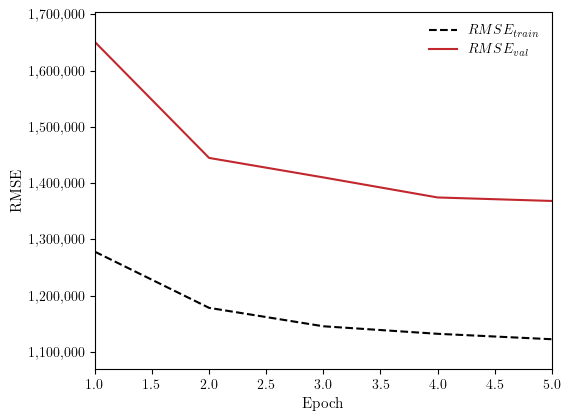

In [ ]:
sf.plot_history(history, save_as=f'../models/{model_name}/history.pdf')

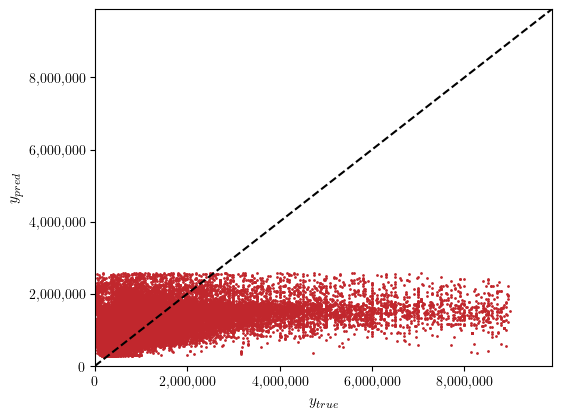

In [ ]:
sf.plot_scatter(predictions, save_as=f'../models/{model_name}/scatter.pdf')

/Users/jonas/Library/CloudStorage/OneDrive-Personal/02_Education/02_Bachelor_Business-Administration/Bachelors-Thesis/Repository/src/shared_functions.py:745: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(y_min - 0.1 * (y_max - y_min), y_max + 0.1 * (y_max - y_min))


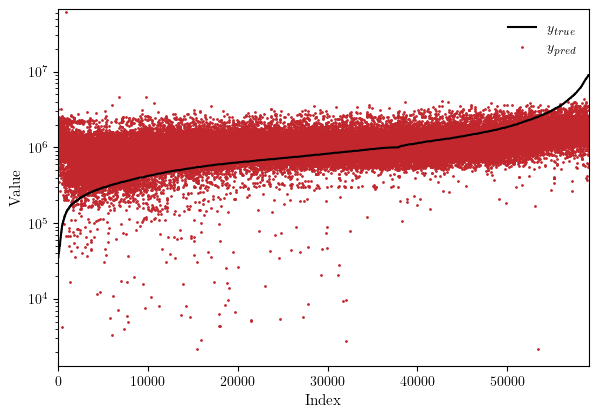

In [ ]:
sf.plot_log(predictions, save_as=f'../models/{model_name}/log.pdf')